# Projektarbeit Machine Learning und Deep Learning (Gruppe 7)
---

Chris-Josip Puclin, Natalie Rudolf, Tina Schiele

**Aufgabenstellung**

* Datensatz: MVTec AD (Quelle: https://www.mvtec.com/company/research/datasets/mvtec-ad)
* Datensatzbeschreibung: „comprises 15 categories with 3629 images for training and validation and 1725 images for testing.The training set contains only images without defects. The test set contains both: images containing various types of defects and defect-free images.“
* Klassifikationsproblem für das gesamte Bild (image-level classification); z.B.: Liegt ein Fehler im aktuellen Bild vor? Um welches Objekt handelt es sich? etc.
* Hierzu müssen zunächst die Metainformationen (Labels) angepasst werden, sowie Training- und Testdatensatz neu gemischt werden.

**Ideen:**
* Stand der Forschung sichten (es gibt etliche Papers, wir möchten uns auf image-level classification fokussieren)
* Man könnte z.B. hierarchische Klassifikation einsetzen: 1) welches Objekt, 2) IO oder NIO
* Man könnte das Problem als two-class classification problem ansehen
* Oder als multi-class classification Problem (Objekt + IO/NIO => 30 Klassen)


Das nachfolgende Projekt orientiert sich in seinem Aufbau und seiner Struktur am CRISP-DM Modell.

## 0. Requirements + Project Structure
---

In [10]:
import os

# Auf das Standardverzeichnis wechseln
os.chdir("/content")

# Prüfen
!pwd


/content


In [11]:
# komplettes Repo aus Github kopieren (für Google Colab)

# ==============================
# 📦 COLAB STARTZELLE (TEAM)
# ==============================

import shutil
import os

# Arbeitsverzeichnis auf /content setzen
os.chdir("/content")

# Name des Repos / Zielordners
repo_name = "MLDL"

# Ordner löschen, falls vorhanden
if os.path.exists(repo_name):
    shutil.rmtree(repo_name)
    print(f"Ordner '{repo_name}' wurde gelöscht")

# Repo klonen
REPO_URL = "https://github.com/NRU310/MLDL.git"
!git clone $REPO_URL

# Ins geklonte Repo wechseln
%cd $repo_name

# Projektpfad setzen
import sys
sys.path.append("src")

Ordner 'MLDL' wurde gelöscht
Cloning into 'MLDL'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 14), reused 8 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 14.39 KiB | 2.40 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/MLDL


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Welche Versionen werden vernwendet?
print("Numpy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-Learn Version:", sklearn.__version__)
print("Torch Version:",torch.__version__)

# relativen Pfad zu den Bilddateien definieren
# Hinweis: Damit der aktuelle Code zum Einlesen der Bilddateien funktioniert, müssen Skript
# und Bilddateien in folgenden Struktur abgespeichert werden (z.B. lokal oder Google Drive)

# [Projektordner]/
# ├── MLDL/
# │   └── gr7_thema1.ipynb   ← Python-Skript (Jupyter Notebook)
# └── data/
#     └── mvtec_anomaly_detection/


PROJECT_ROOT = Path.cwd().resolve()
DATA_ROOT = (PROJECT_ROOT / ".." / "data").resolve()
BASE_DIR = DATA_ROOT / "mvtec_anomaly_detection"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print(BASE_DIR)

## 1. Project Understanding
---
*Papers, die sich mit image-level classification beschäftigen*

Wissenschaftliche Papers:
* Research on Image Classification Algorithm Based on Pytorch (https://iopscience.iop.org/article/10.1088/1742-6596/2010/1/012009/meta)
* Multi-class Image Classification Using Deep Learning Algorithm (https://iopscience.iop.org/article/10.1088/1742-6596/1447/1/012021/meta)

Bücher:
* Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und TensorFlow, z.B. Kapitel 14 (verfügbar als e-book im Bibliothekskatalog)



*qualitative Beschreibung, was wir tun wollen*

**image-level classification**
* two-class classification problem
* multi-class classification problem (Objekt + IO/NIO => 30 Klassen)



## 2. Data Understanding und Data Preparation
---

*Datensatz verstehen und näher untersuchen: „comprises 15 categories with 3629 images for training and validation and 1725 images for testing.The training set contains only images without defects. The test set contains both: images containing various types of defects and defect-free images.“*

*Metainformationen (Labels) anpassen sowie Trainings- und Testdatensatz neu mischen*

In [3]:
# Labeling

records = []

for category_dir in BASE_DIR.iterdir():
    if not category_dir.is_dir():
        continue

    category = category_dir.name

    for split_dir in category_dir.iterdir():
        if not split_dir.is_dir():
            continue
        if split_dir.name not in ["train", "test"]:
            continue

        for defect_dir in split_dir.iterdir():
            if not defect_dir.is_dir():
                continue

            defect_name = defect_dir.name

            for img_path in defect_dir.glob("*.png"):

                if defect_name == "good":
                    io_status = "io"
                    defect_type = None
                else:
                    io_status = "nio"
                    defect_type = defect_name

                records.append({
                    "filepath": str(img_path.relative_to(DATA_ROOT)),
                    "category": category,
                    "io_status": io_status,
                    "defect_type": defect_type
                })

df_labels = pd.DataFrame(records)
df_labels

,filepath,category,io_status,defect_type
0,mvtec_anomaly_detection\bottle\test\broken_lar...,bottle,nio,broken_large
1,mvtec_anomaly_detection\bottle\test\broken_lar...,bottle,nio,broken_large
2,mvtec_anomaly_detection\bottle\test\broken_lar...,bottle,nio,broken_large
3,mvtec_anomaly_detection\bottle\test\broken_lar...,bottle,nio,broken_large
4,mvtec_anomaly_detection\bottle\test\broken_lar...,bottle,nio,broken_large
...,...,...,...,...
5349,mvtec_anomaly_detection\zipper\train\good\235.png,zipper,io,None
5350,mvtec_anomaly_detection\zipper\train\good\236.png,zipper,io,None
5351,mvtec_anomaly_detection\zipper\train\good\237.png,zipper,io,None
5352,mvtec_anomaly_detection\zipper\train\good\238.png,zipper,io,None


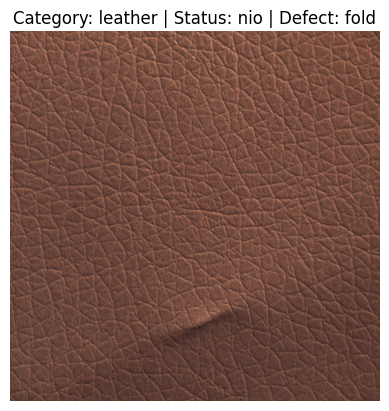

In [16]:
# ein zufälliges Bild auswählen
row = df_labels.sample(1).iloc[0]

img_path = DATA_ROOT / row["filepath"]
assert img_path.exists(), f"Datei nicht gefunden: {img_path}"

img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.title(
    f"Category: {row['category']} | "
    f"Status: {row['io_status']} | "
    f"Defect: {row['defect_type']}"
)
plt.show()

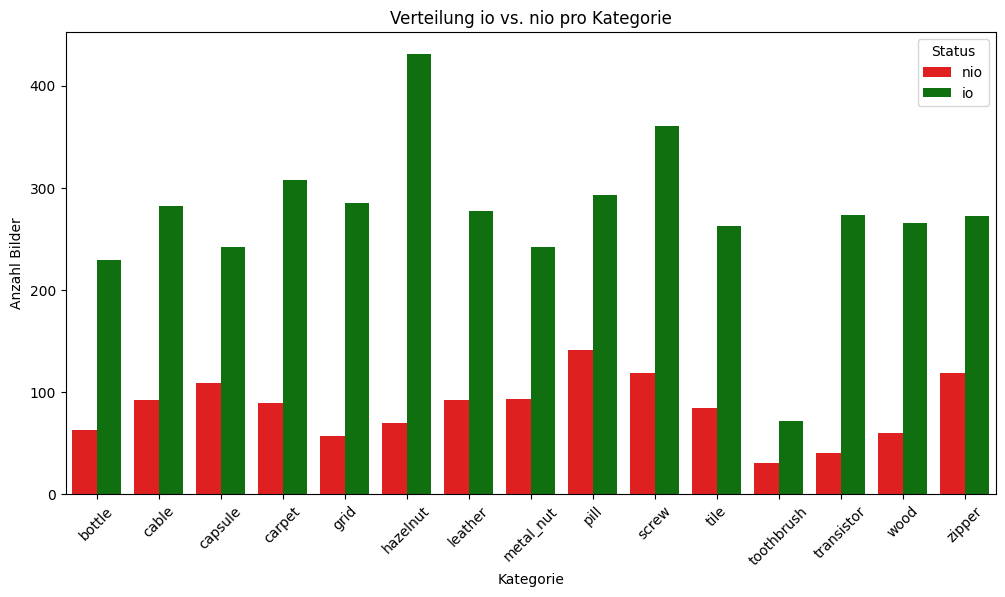

In [4]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_labels, x='category', hue='io_status', palette={'io':'green','nio':'red'})
plt.title('Verteilung io vs. nio pro Kategorie')
plt.ylabel('Anzahl Bilder')
plt.xlabel('Kategorie')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.show()

In [11]:
# Test und Trainingsdaten splitten für Multi-Class Classification (Kombination aus Kategorie + io-Status als Label)

# kombiniertes Label für stratify
df_labels['stratify_label'] = df_labels['category'] + "_" + df_labels['io_status']

train_df, test_df = train_test_split(
    df_labels,
    test_size=0.2,  # 20% Testset
    random_state=42,
    stratify=df_labels['stratify_label']
)

# Validation-Set
train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,  # 10% des Trainings für Validierung
    random_state=42,
    stratify=train_df['stratify_label']
)

# Textlabels in numerische Klassen umwandeln (notwendig für PyTorch/TensorFlow)

le = LabelEncoder()

# Training: fit + transform
train_df['class_id'] = le.fit_transform(train_df['stratify_label'])

# Validation: nur transform, gleiche IDs wie im Train
val_df['class_id'] = le.transform(val_df['stratify_label'])

# Test: nur transform, gleiche IDs wie im Train
test_df['class_id'] = le.transform(test_df['stratify_label'])

print(dict(zip(le.classes_, range(len(le.classes_)))))

{'bottle_io': 0, 'bottle_nio': 1, 'cable_io': 2, 'cable_nio': 3, 'capsule_io': 4, 'capsule_nio': 5, 'carpet_io': 6, 'carpet_nio': 7, 'grid_io': 8, 'grid_nio': 9, 'hazelnut_io': 10, 'hazelnut_nio': 11, 'leather_io': 12, 'leather_nio': 13, 'metal_nut_io': 14, 'metal_nut_nio': 15, 'pill_io': 16, 'pill_nio': 17, 'screw_io': 18, 'screw_nio': 19, 'tile_io': 20, 'tile_nio': 21, 'toothbrush_io': 22, 'toothbrush_nio': 23, 'transistor_io': 24, 'transistor_nio': 25, 'wood_io': 26, 'wood_nio': 27, 'zipper_io': 28, 'zipper_nio': 29}


## 3. Modeling
---

## 4. Evaluation
---

## 5. Deployment
---

*Dieser Schritt entfällt, da der entwickelte Algorithmus nicht produktiv genutzt werden soll. Die Ergebnisse werden in der Abschlusspräsentation vorgestellt.*